---
title: C++ 网络编程 socket的阻塞和非阻塞模式 与 send 和 recv 函数
tags: 小书匠,Network|计算机网络,c++,socket,block,send,recv,write,read小书匠,Network|计算机网络,c++,socket,block,send,recv,write,read
grammar_cjkRuby: true
renderNumberedHeading: true
---

[toc]

# C++ 网络编程 socket的阻塞和非阻塞模式 与 send 和 recv 函数

## 什么是阻塞和非阻塞

- 阻塞模式，就当某个函数“执行成功的条件”当前不能满足时，该函数会阻塞当前执行线程，程序执行流在超时时间到达或“执行成功的条件”满足后恢复继续执行。
- 而非阻塞模式恰恰相反，即使某个函数的“执行成功的条件”不当前不能满足，该函数也不会阻塞当前执行线程，而是立即返回，继续运行执行程序流。

## 如何将 send 和 recv 设置为非阻塞模式？

阻塞和非阻塞实际上不是 send 和 recv 函数的特性，而是 socket 自身的特性。

默认生成的 socket 是阻塞模式，在 linux 中，有两种方式可以将 socket 设置为非阻塞模式。

### 在创建时指定为非阻塞模式

```cpp
#include <sys/socket.h>
#include <netinet/in.h>

int sock = socket(AF_INET, SOCK_STREAM | O_NONBLOCK, 0);
```

### 使用 fnctl 将已有的 socket 修改为非阻塞模式

使用下面的代码可以将一个文件描述符修改为非阻塞模式

```cpp
#include <fcntl.h>

int setnonblocking(int fd)
{
    int old_option = fcntl(fd, F_GETFL);  // 获取旧的文件描述符的状态
    int new_option = old_option | O_NONBLOCK; // 设置非阻塞模式
    fcntl(fd, F_SETFL, new_option);
    return old_option; // 返回旧的状态，以便恢复
}
```

## send 和 recv 的本质

send 和 recv 的作用并非真正的发送和接受数据，这些实际上是系统内核完成的。

send 的作用是将应用程序中的数据放到内核缓冲区中，而 recv 的作用是将内核缓冲区中的数据放到应用程序中。

而真正的发送和接受数据是在内核层面在内核缓冲区之间完成的。

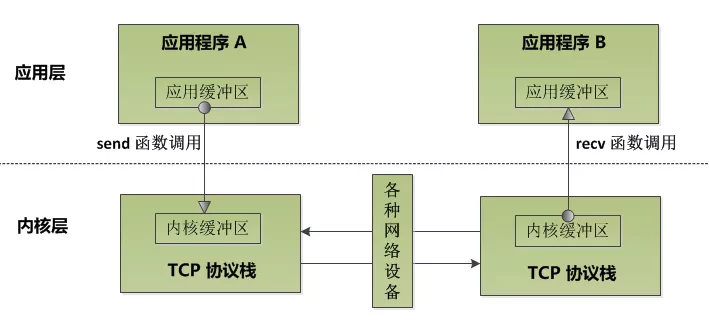

## socket 阻塞模式下的 send 行为

为了观察到 send 函数的阻塞状态，我们需要使用 gdb 来暂停函数并查看调用栈。

1. 我们编写一个 server.cpp 让 server 只处理连接，而不接受数据，即 server 只 accept，而不 recv
2. 编写一个 client.cpp，向 server 不断发送数据

### blocking_server.cpp

In [13]:
%%file blocking_server.cpp
#include <sys/types.h> 
#include <sys/socket.h>
#include <arpa/inet.h>
#include <unistd.h>
#include <iostream>
#include <string.h>

int main(int argc, char* argv[])
{
    //1.创建一个侦听socket
    int listenfd = socket(AF_INET, SOCK_STREAM, 0);
    if (listenfd == -1)
    {
        std::cout << "create listen socket error." << std::endl;
        return -1;
    }

    //2.初始化服务器地址
    struct sockaddr_in bindaddr;
    bindaddr.sin_family = AF_INET;
    bindaddr.sin_addr.s_addr = htonl(INADDR_ANY);
    bindaddr.sin_port = htons(3000);
    if (bind(listenfd, (struct sockaddr *)&bindaddr, sizeof(bindaddr)) == -1)
    {
        std::cout << "bind listen socket error." << std::endl;
        close(listenfd);
        return -1;
    }

    //3.启动侦听
    if (listen(listenfd, SOMAXCONN) == -1)
    {
        std::cout << "listen error." << std::endl;
        close(listenfd);
        return -1;
    }

    while (true)
    {
        struct sockaddr_in clientaddr;
        socklen_t clientaddrlen = sizeof(clientaddr);
        //4. 接受客户端连接
        int clientfd = accept(listenfd, (struct sockaddr *)&clientaddr, &clientaddrlen);
        if (clientfd != -1)
        {             
            //只接受连接，不调用recv收取任何数据
            std:: cout << "accept a client connection." << std::endl;
        }
    }

    //7.关闭侦听socket
    close(listenfd);

    return 0;
}

Writing blocking_server.cpp


### blocking_client.cpp

In [14]:
%%file blocking_client.cpp
#include <sys/types.h> 
#include <sys/socket.h>
#include <arpa/inet.h>
#include <unistd.h>
#include <iostream>
#include <string.h>

#define SERVER_ADDRESS "127.0.0.1"
#define SERVER_PORT     3000
#define SEND_DATA       "helloworld"

int main(int argc, char* argv[])
{
    //1.创建一个socket
    int clientfd = socket(AF_INET, SOCK_STREAM, 0);
    if (clientfd == -1)
    {
        std::cout << "create client socket error." << std::endl;
        close(clientfd);
        return -1;
    }

    //2.连接服务器
    struct sockaddr_in serveraddr;
    serveraddr.sin_family = AF_INET;
    serveraddr.sin_addr.s_addr = inet_addr(SERVER_ADDRESS);
    serveraddr.sin_port = htons(SERVER_PORT);
    if (connect(clientfd, (struct sockaddr *)&serveraddr, sizeof(serveraddr)) == -1)
    {
        std::cout << "connect socket error." << std::endl;
        return -1;
    }

    //3. 不断向服务器发送数据，或者出错退出
    int count = 0;
    while (true)
    {
        int ret = send(clientfd, SEND_DATA, strlen(SEND_DATA), 0);
        if (ret != strlen(SEND_DATA))
        {
            std::cout << "send data error." << std::endl;
            break;
        } 
        else
        {
            count ++;
            std::cout << "send data successfully, count = " << count << std::endl;
        }
    }

    //5. 关闭socket
    close(clientfd);

    return 0;
}

Overwriting blocking_client.cpp


### 运行

使用 -g 参数编译，从而可以使用 gdb 来调试

In [15]:
!g++ blocking_server.cpp -g -o blocking_server

In [16]:
!g++ blocking_client.cpp -g -o blocking_client

打开两个窗口，一个运行 `./server` 命令，另一个运行 `gdb client`，此时 `./server` 会提示有客户端连接，并且客户端会不停向 server 发送数据。

server 的输出
```bash
[root@localhost testsocket]# ./server 
accept a client connection.
```

client 的输出

```bash
[root@localhost testsocket]# gdb client
GNU gdb (GDB) Red Hat Enterprise Linux 7.6.1-100.el7_4.1
Copyright (C) 2013 Free Software Foundation, Inc.
License GPLv3+: GNU GPL version 3 or later <http://gnu.org/licenses/gpl.html>
This is free software: you are free to change and redistribute it.
There is NO WARRANTY, to the extent permitted by law.  Type "show copying"
and "show warranty" for details.
This GDB was configured as "x86_64-redhat-linux-gnu".
For bug reporting instructions, please see:
<http://www.gnu.org/software/gdb/bugs/>...
Reading symbols from /root/testsocket/blocking_client...done.
(gdb) run
//输出结果太多，省略部分...
send data successfully, count = 355384
send data successfully, count = 355385
send data successfully, count = 355386
send data successfully, count = 355387
send data successfully, count = 355388
send data successfully, count = 355389
send data successfully, count = 355390
```

当 client 输出到一定程度时，会停止输出，此时缓冲区被填满，send 处于阻塞状态。为了证实这一点，在 client 的窗口使用 `ctrl + c` 暂停程序，并使用 `bt` 命令输出当前的调用栈，可以看到当前运行的函数正是 send 函数

```bash
^C
Program received signal SIGINT, Interrupt.
0x00007ffff72ec9bd in send () from /lib64/libc.so.6
Missing separate debuginfos, use: debuginfo-install glibc-2.17-324.el7_9.x86_64 libgcc-4.8.5-44.el7.x86_64 libstdc++-4.8.5-44.el7.x86_64
(gdb) br
Breakpoint 1 at 0x7ffff72ec9bd
(gdb) bt
#0  0x00007ffff72ec9bd in send () from /lib64/libc.so.6
#1  0x0000000000400b50 in main (argc=1, argv=0x7fffffffe1e8) at client.cpp:42
(gdb)
```

## socket 非阻塞模式下的 send 行为

### nonblocking_client.cpp

In [11]:
%%file nonblocking.cpp
#include <sys/types.h> 
#include <sys/socket.h>
#include <arpa/inet.h>
#include <unistd.h>
#include <iostream>
#include <string.h>
#include <stdio.h>
#include <fcntl.h>
#include <errno.h>

#define SERVER_ADDRESS "127.0.0.1"
#define SERVER_PORT     3000
#define SEND_DATA       "helloworld"

int setnonblocking(int fd)
{
    int old_option = fcntl(fd, F_GETFL);  // 获取旧的文件描述符的状态
    int new_option = old_option | O_NONBLOCK; // 设置非阻塞模式
    fcntl(fd, F_SETFL, new_option);
    return old_option; // 返回旧的状态，以便恢复
}

int main(int argc, char* argv[])
{
    //1.创建一个socket
    int clientfd = socket(AF_INET, SOCK_STREAM, 0);
    if (clientfd == -1)
    {
        std::cout << "create client socket error." << std::endl;
        return -1;
    }

    //2.连接服务器
    struct sockaddr_in serveraddr;
    serveraddr.sin_family = AF_INET;
    serveraddr.sin_addr.s_addr = inet_addr(SERVER_ADDRESS);
    serveraddr.sin_port = htons(SERVER_PORT);
    if (connect(clientfd, (struct sockaddr *)&serveraddr, sizeof(serveraddr)) == -1)
    {
        std::cout << "connect socket error." << std::endl;
        close(clientfd);
        return -1;
    }

    //连接成功以后，我们再将 clientfd 设置成非阻塞模式，
    //不能在创建时就设置，这样会影响到 connect 函数的行为
    setnonblocking(clientfd);

    //3. 不断向服务器发送数据，或者出错退出
    int count = 0;
    while (true)
    {
        int ret = send(clientfd, SEND_DATA, strlen(SEND_DATA), 0);
        if (ret == -1)  // 发送失败
        {
            //非阻塞模式下send函数由于TCP窗口太小发不出去数据，错误码是EWOULDBLOCK
            if (errno == EWOULDBLOCK)
            {
                std::cout << "send data error as TCP Window size is too small." << std::endl;
                continue;
            } 
            else if (errno == EINTR)
            {
                //如果被信号中断，我们继续重试
                std::cout << "sending data interrupted by signal." << std::endl;
                continue;
            } 
            else 
            {
                std::cout << "send data error." << std::endl;
                break;
            }
        }
        else if (ret == 0) //对端关闭了连接，我们也关闭
        {
            std::cout << "send data error." << std::endl;
            close(clientfd);
            break;
        } 
        else // 发送成功
        {
            count ++;
            std::cout << "send data successfully, count = " << count << std::endl;
        }
    }

    //5. 关闭socket
    close(clientfd);

    return 0;
}

Writing nonblocking.cpp


### 运行

编译

In [9]:
!g++ nonblocking_client.cpp -g -o nonblocking_client 

In [9]:
!g++ blocking.cpp -g -o nonblocking_client 

开两个窗口，一个运行 `./blocking_server`，一个运行 `./nonblocking_client`，此时不需要 gdb 来辅助观察程序，因为 `./nonblocking_client` 不会阻塞。

`nonblocking_client` 运行开始时的表现和 `blocking_client` 相同，而当将 tcp 窗口填满之后，表现和 `blocking_client` 不同，此时调用 `send` 返回值为 -1，同时 errno 为 `EWOULDBLOCK`，此时会输出 `send data error as TCP Window size is too small.` 提示信息。而 `blocking_client` 此时 send 会一直等待，不会返回。

## socket 阻塞模式下 recv 的行为

### blocking_client_recv.cpp

In [28]:
%%file blocking_client_recv.cpp
#include <sys/types.h> 
#include <sys/socket.h>
#include <arpa/inet.h>
#include <unistd.h>
#include <iostream>
#include <string.h>

#define SERVER_ADDRESS "127.0.0.1"
#define SERVER_PORT     3000
#define BUFF_SIZE       1024

int main(int argc, char* argv[])
{
    //1.创建一个socket
    int clientfd = socket(AF_INET, SOCK_STREAM, 0);
    if (clientfd == -1)
    {
        std::cout << "create client socket error." << std::endl;
        close(clientfd);
        return -1;
    }

    //2.连接服务器
    struct sockaddr_in serveraddr;
    serveraddr.sin_family = AF_INET;
    serveraddr.sin_addr.s_addr = inet_addr(SERVER_ADDRESS);
    serveraddr.sin_port = htons(SERVER_PORT);
    if (connect(clientfd, (struct sockaddr *)&serveraddr, sizeof(serveraddr)) == -1)
    {
        std::cout << "connect socket error." << std::endl;
        return -1;
    }

    char buff[BUFF_SIZE];
    //3. 不断向服务器发送数据，或者出错退出
    int count = 0;
    while (true)
    {
        int ret = recv(clientfd, buff, sizeof(buff), 0);
        if (ret == -1)
        {
            std::cout << "recv data error." << std::endl;
            break;
        } 
        else
        {
            count++;
            std::cout << "recv data successfully, count = " << count << std::endl;
        }
    }

    //5. 关闭socket
    close(clientfd);

    return 0;
}

Overwriting blocking_client_recv.cpp


同样开两个窗口
1. 先启动 server `./blocking_server`
2. 再使用 gdb 启动 client, `gdb blocking_client_recv`，然后输入 `run` 启动程序，发现 client 没有任何输出，因为此时已经阻塞在 `recv` 函数了。
3. 为了验证 `blocking_client_recv` 阻塞在 `recv` 函数，可以使用 `ctrl + c` 暂停客户端程序，并使用 bt 输出调用栈，看到栈顶是 recv 函数，说明客户端的确卡在 `recv` 函数了

```bash?linenums&fancy=19
[root@localhost Linux高性能服务器编程]# gdb blocking_client_recv
GNU gdb (GDB) Red Hat Enterprise Linux 7.6.1-120.el7
Copyright (C) 2013 Free Software Foundation, Inc.
License GPLv3+: GNU GPL version 3 or later <http://gnu.org/licenses/gpl.html>
This is free software: you are free to change and redistribute it.
There is NO WARRANTY, to the extent permitted by law.  Type "show copying"
and "show warranty" for details.
This GDB was configured as "x86_64-redhat-linux-gnu".
For bug reporting instructions, please see:
<http://www.gnu.org/software/gdb/bugs/>...
Reading symbols from /root/Git/learnCpp/Linux高性能服务器编程/blocking_client_recv...done.
(gdb) run
Starting program: /root/Git/learnCpp/Linux高性能服务器编程/blocking_client_recv 
^C
Program received signal SIGINT, Interrupt.
0x00007ffff72ec84d in recv () from /lib64/libc.so.6
Missing separate debuginfos, use: debuginfo-install glibc-2.17-324.el7_9.x86_64 libgcc-4.8.5-44.el7.x86_64 libstdc++-4.8.5-44.el7.x86_64
(gdb) bt
#0  0x00007ffff72ec84d in recv () from /lib64/libc.so.6
#1  0x0000000000400b5b in main (argc=1, argv=0x7fffffffe1d8)
    at blocking_client_recv.cpp:39
(gdb)
```

## socket 非阻塞模式下 recv 的行为

### nonblocking_client_recv.cpp

In [26]:
%%file nonblocking_client_recv.cpp
#include <sys/types.h> 
#include <sys/socket.h>
#include <arpa/inet.h>
#include <unistd.h>
#include <iostream>
#include <string.h>
#include <fcntl.h>
#include <errno.h>

#define SERVER_ADDRESS "127.0.0.1"
#define SERVER_PORT     3000
#define BUFF_SIZE       1024

int setnonblocking(int fd)
{
    int old_option = fcntl(fd, F_GETFL);  // 获取旧的文件描述符的状态
    int new_option = old_option | O_NONBLOCK; // 设置非阻塞模式
    fcntl(fd, F_SETFL, new_option);
    return old_option; // 返回旧的状态，以便恢复
}

int main(int argc, char* argv[])
{
    //1.创建一个socket
    int clientfd = socket(AF_INET, SOCK_STREAM, 0);
    if (clientfd == -1)
    {
        std::cout << "create client socket error." << std::endl;
        close(clientfd);
        return -1;
    }

    //2.连接服务器
    struct sockaddr_in serveraddr;
    serveraddr.sin_family = AF_INET;
    serveraddr.sin_addr.s_addr = inet_addr(SERVER_ADDRESS);
    serveraddr.sin_port = htons(SERVER_PORT);
    if (connect(clientfd, (struct sockaddr *)&serveraddr, sizeof(serveraddr)) == -1)
    {
        std::cout << "connect socket error." << std::endl;
        return -1;
    }

    setnonblocking(clientfd);
    char buff[BUFF_SIZE];
    //3. 不断向服务器发送数据，或者出错退出
    int count = 0;
    while (true)
    {
        int ret = recv(clientfd, buff, sizeof(buff), 0);
        if (ret == -1)
        {
            if (errno == EWOULDBLOCK)
            {
                std::cout << "There is no data available now." << std::endl;
            } 
            else if (errno == EINTR) 
            {
                //如果被信号中断了，则继续重试recv函数
                std::cout << "recv data interrupted by signal." << std::endl;               
            } else
            {
                //真的出错了
                break;
            }
        } 
        else if (ret == 0) // 关闭连接了
        {
            std::cout << "peer close the connection" << std::endl;
        }
        else // 接受成功
        {
            count++;
            std::cout << "recv data successfully, count = " << count << std::endl;
        }
    }

    //5. 关闭socket
    close(clientfd);

    return 0;
}

Overwriting nonblocking_client_recv.cpp


编译

In [27]:
!g++ nonblocking_client_recv.cpp -g -o nonblocking_client_recv

同样开两个窗口
1. 先启动 server `./blocking_server`
2. 再启动 client `./nonblocking_client_recv`

# References

- [socket 的阻塞模式和非阻塞模式 · 高性能服务器开发 技术专栏](http://balloonwj.gitee.io/cpp-guide-web/articles/%E7%BD%91%E7%BB%9C%E7%BC%96%E7%A8%8B/socket%E7%9A%84%E9%98%BB%E5%A1%9E%E6%A8%A1%E5%BC%8F%E5%92%8C%E9%9D%9E%E9%98%BB%E5%A1%9E%E6%A8%A1%E5%BC%8F.html)